In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import SeparableConv2D
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import cv2
import concurrent.futures

In [2]:
# Configuration
IMG_HEIGHT = 128
IMG_WIDTH = 160
BATCH_SIZE = 8
EPOCHS = 50

In [3]:
def load_image_pair(blur_path, sharp_path):
    blur_img = load_img(blur_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    sharp_img = load_img(sharp_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

    blur_arr = img_to_array(blur_img) / 255.0
    sharp_arr = img_to_array(sharp_img) / 255.0
    return blur_arr, sharp_arr

In [4]:
def process_image_pair(args):
    blur_img_path, sharp_img_path = args
    if os.path.exists(sharp_img_path):
        return load_image_pair(blur_img_path, sharp_img_path)
    return None

def load_dataset(blurry_dir='BlurryVision/BLURRY', gt_dir='BlurryVision/GT'):
    X, Y = [], []
    image_pairs = []

    for filename in os.listdir(blurry_dir):
        blur_img_path = os.path.join(blurry_dir, filename)
        sharp_img_path = os.path.join(gt_dir, filename)
        image_pairs.append((blur_img_path, sharp_img_path))

    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(process_image_pair, image_pairs))

    for result in results:
        if result:
            X.append(result[0])
            Y.append(result[1])

    return np.array(X), np.array(Y)
X_train, Y_train = load_dataset()

In [5]:
# U-Net definition
BASE_FILTERS = 32
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(inputs)
    c1 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(p1)
    c2 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 =SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(p2)
    c3 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    c4 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(p3)
    c4 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D()(c4)

    # Bottleneck
    c5 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(p4)
    c5 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.UpSampling2D()(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(u6)
    c6 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D()(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(u7)
    c7 =SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(c7)

    u8 = layers.UpSampling2D()(c7)
    u8 = layers.concatenate([u8, c2])
    c8 =SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(u8)
    c8 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(c8)

    u9 = layers.UpSampling2D()(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(u9)
    c9 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(3, 1, activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model

In [6]:
model = unet_model()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae','accuracy'])
model.summary()

model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=400, validation_split=0.1, verbose =1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 160, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d              │ (None, 128, 160, 32)      │             155 │ input_layer[0][0]          │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_1            │ (None, 128, 160, 32)      │           1,344 │ separable_conv2d[0][0]     │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 64, 80, 32)        │               0 │ separable_conv2d_1[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_2            │ (None, 64, 80, 32)        │           1,344 │ max_pooling2d[0][0]        │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_3            │ (None, 64, 80, 32)        │           1,344 │ separable_conv2d_2[0][0]   │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 32, 40, 32)        │               0 │ separable_conv2d_3[0][0]   │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_4            │ (None, 32, 40, 32)        │           1,344 │ max_pooling2d_1[0][0]      │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_5            │ (None, 32, 40, 32)        │           1,344 │ separable_conv2d_4[0][0]   │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 16, 20, 32)        │               0 │ separable_conv2d_5[0][0]   │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_6            │ (None, 16, 20, 32)        │           1,344 │ max_pooling2d_2[0][0]      │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_7            │ (None, 16, 20, 32)        │           1,344 │ separable_conv2d_6[0][0]   │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 28,350 (110.74 KB)

 Trainable params: 28,350 (110.74 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/400
79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 272ms/step - accuracy: 5.7965e-05 - loss: 0.1467 - mae: 0.3695 - val_accuracy: 0.0000e+00 - val_loss: 0.0183 - val_mae: 0.0847
Epoch 2/400
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.0037 - loss: 0.0102 - mae: 0.0636 - val_accuracy: 0.2893 - val_loss: 0.0051 - val_mae: 0.0476
Epoch 3/400
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 234ms/step - accuracy: 0.1489 - loss: 0.0043 - mae: 0.0434 - val_accuracy: 0.4339 - val_loss: 0.0045 - val_mae: 0.0452
Epoch 4/400
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 234ms/step - accuracy: 0.2460 - loss: 0.0038 - mae: 0.0411 - val_accuracy: 0.0740 - val_loss: 0.0042 - val_mae: 0.0439
Epoch 5/400
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 219ms/step - accuracy: 0.1195 - loss: 0.0036 - mae: 0.0403 - val_accuracy: 0.2931 - val_loss: 0.0041 - val_mae: 0.0431
Epoch 6/400
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.4195 - loss: 0.0035 - mae: 0.0394 - val_accuracy: 0.2827 - val_loss: 0.0040 - val_mae: 0.0428
Epoch 7/400
79/79 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


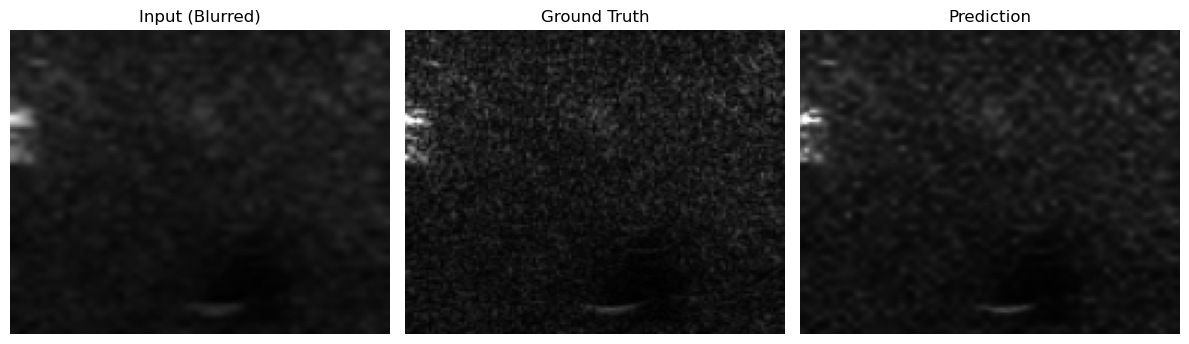

In [7]:
blur_in = cv2.imread("C:/Users/HARSH SAXENA/Desktop/Task 9/BlurryVision/BlURRY/img_003_05_0.png")
gt = cv2.imread("C:/Users/HARSH SAXENA/Desktop/Task 9/BlurryVision/GT/img_003_05_0.png")

blur_rgb = cv2.cvtColor(blur_in, cv2.COLOR_BGR2RGB)
gt_rgb = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)

input_img = cv2.resize(blur_rgb, (160, 128)) / 255.0
gt_img = cv2.resize(gt_rgb, (160, 128)) / 255.0

input_batch = np.expand_dims(input_img, axis=0)

pred = model.predict(input_batch)
pred_img = np.squeeze(pred)
input_img = np.squeeze(input_batch)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(input_img)
plt.title("Input (Blurred)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(gt_img)
plt.title("Ground Truth")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(pred_img)
plt.title("Prediction")
plt.axis('off')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


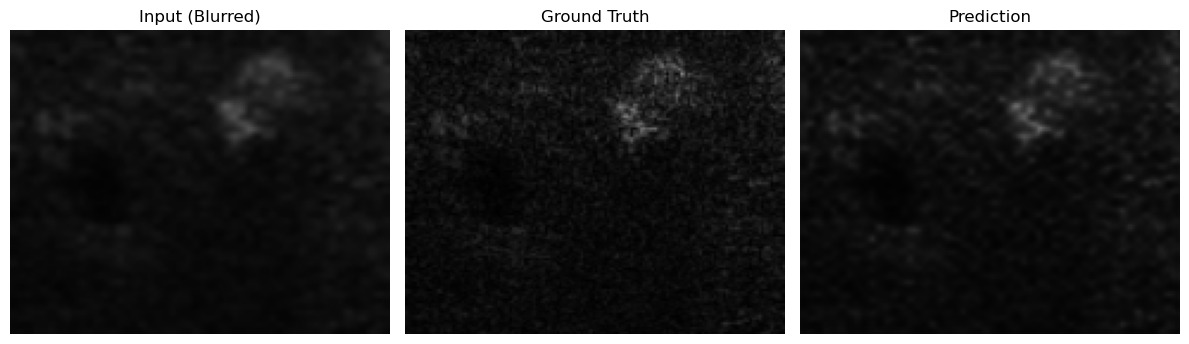

In [8]:
blur_in = cv2.imread("C:/Users/HARSH SAXENA/Desktop/Task 9/BlurryVision/BlURRY/img_004_05_0.png")
gt = cv2.imread("C:/Users/HARSH SAXENA/Desktop/Task 9/BlurryVision/GT/img_004_05_0.png")

blur_rgb = cv2.cvtColor(blur_in, cv2.COLOR_BGR2RGB)
gt_rgb = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)

input_img = cv2.resize(blur_rgb, (160, 128)) / 255.0
gt_img = cv2.resize(gt_rgb, (160, 128)) / 255.0

input_batch = np.expand_dims(input_img, axis=0)

pred = model.predict(input_batch)
pred_img = np.squeeze(pred)
input_img = np.squeeze(input_batch)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(input_img)
plt.title("Input (Blurred)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(gt_img)
plt.title("Ground Truth")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(pred_img)
plt.title("Prediction")
plt.axis('off')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


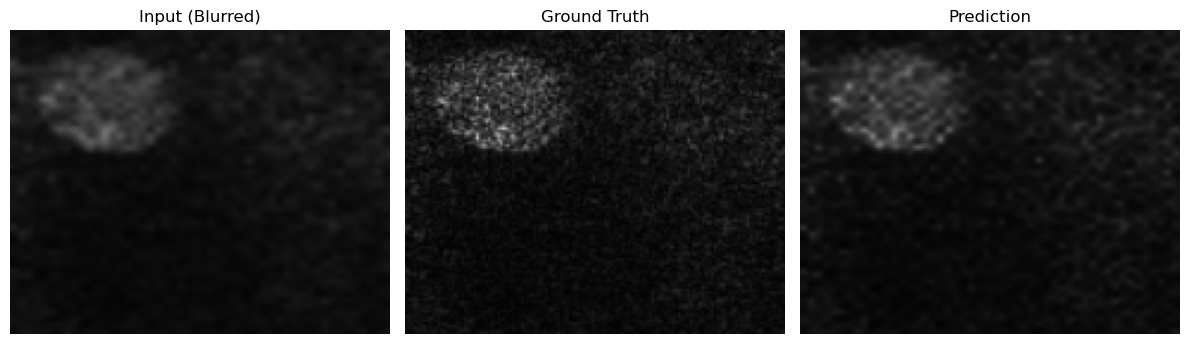

In [9]:
blur_in = cv2.imread("C:/Users/HARSH SAXENA/Desktop/Task 9/BlurryVision/BlURRY/img_005_05_0.png")
gt = cv2.imread("C:/Users/HARSH SAXENA/Desktop/Task 9/BlurryVision/GT/img_005_05_0.png")

blur_rgb = cv2.cvtColor(blur_in, cv2.COLOR_BGR2RGB)
gt_rgb = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)

input_img = cv2.resize(blur_rgb, (160, 128)) / 255.0
gt_img = cv2.resize(gt_rgb, (160, 128)) / 255.0

input_batch = np.expand_dims(input_img, axis=0)

pred = model.predict(input_batch)
pred_img = np.squeeze(pred)
input_img = np.squeeze(input_batch)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(input_img)
plt.title("Input (Blurred)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(gt_img)
plt.title("Ground Truth")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(pred_img)
plt.title("Prediction")
plt.axis('off')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


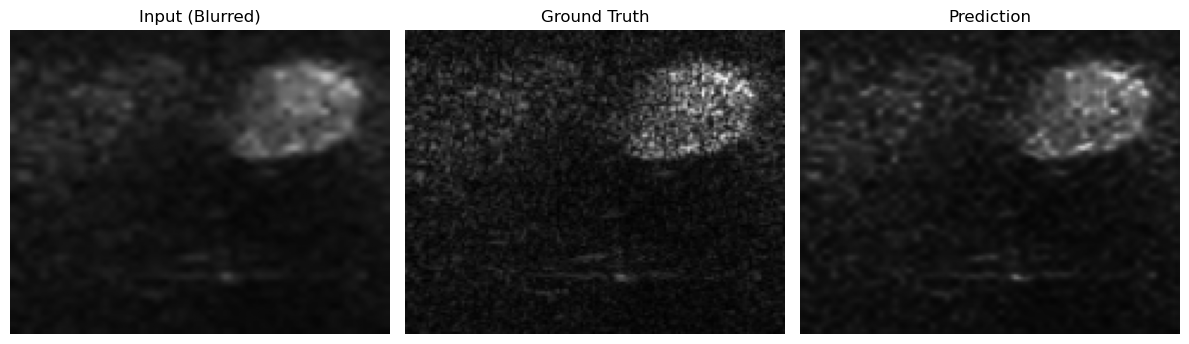

In [10]:
blur_in = cv2.imread("C:/Users/HARSH SAXENA/Desktop/Task 9/BlurryVision/BlURRY/img_006_05_0.png")
gt = cv2.imread("C:/Users/HARSH SAXENA/Desktop/Task 9/BlurryVision/GT/img_006_05_0.png")

blur_rgb = cv2.cvtColor(blur_in, cv2.COLOR_BGR2RGB)
gt_rgb = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)

input_img = cv2.resize(blur_rgb, (160, 128)) / 255.0
gt_img = cv2.resize(gt_rgb, (160, 128)) / 255.0

input_batch = np.expand_dims(input_img, axis=0)

pred = model.predict(input_batch)
pred_img = np.squeeze(pred)
input_img = np.squeeze(input_batch)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(input_img)
plt.title("Input (Blurred)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(gt_img)
plt.title("Ground Truth")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(pred_img)
plt.title("Prediction")
plt.axis('off')

plt.tight_layout()
plt.show()

In [11]:
model.save("unet_denoising_model_200_bw.h5")
model.save("unet_denoising_model_200_bw.keras")